In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(qvalue)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [2]:
revision_folder = "/hps/nobackup2/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/"

In [4]:
crm_file = paste0(revision_folder, "Annas_results_all_common_eqtls.csv")
crm = read.csv(crm_file, row.names=1)

In [5]:
crm_assoc = crm[crm$chrom %in% c(20,21,22),]

In [6]:
head(crm_assoc)

,gene,n_snps,chrom,pv_raw,snpID,pv,eqtl
7476,ENSG00000100206,639,22,0.4846768,22_38815543_G_T,1,ENSG00000100206-22_38815543_G_T
7477,ENSG00000100206,639,22,0.5735132,22_38815767_C_T,1,ENSG00000100206-22_38815767_C_T
7478,ENSG00000100206,639,22,0.8756466,22_38816059_T_C,1,ENSG00000100206-22_38816059_T_C
7479,ENSG00000100206,639,22,0.1460246,22_38816351_G_A,1,ENSG00000100206-22_38816351_G_A
7480,ENSG00000100206,639,22,0.2546127,22_38817047_A_G,1,ENSG00000100206-22_38817047_A_G
7481,ENSG00000100206,639,22,0.1834585,22_38817105_C_T,1,ENSG00000100206-22_38817105_C_T


In [7]:
res_dir = "/hps/nobackup2/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/CRM_interaction_chr22/results/"
all_files = list.files(res_dir)
length(all_files)

[1] 34742

In [8]:
correct_files = list.files(res_dir,"*0.tsv")
length(correct_files)

[1] 34741

In [9]:
all_files[!(all_files %in% correct_files)]

[1] "summary.csv"

In [10]:
crm_int_file = paste0(revision_folder, "CRM_interaction_chr22/results/summary.csv")
crm_int = read.csv(crm_int_file, row.names=1)
nrow(crm_int)
head(crm_int,2)

[1] 344430

,gene,n_snps,chrom,pv_raw,snpID
0,ENSG00000250479,10,22,0.3439653,22_24071877_G_A
1,ENSG00000250479,10,22,0.4098352,22_24072256_G_C


In [11]:
crm_int_file

[1] "/hps/nobackup2/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/CRM_interaction_chr22/results/summary.csv"

In [12]:
unique(as.character(crm_int$chrom))

[1] "22" "20" "21"

In [13]:
# unique(as.character(crm_int[crm_int$chrom == 20, ]$gene))
length(unique(as.character(crm_int[crm_int$chrom == 20, ]$gene)))
length(unique(as.character(crm_int[crm_int$chrom == 21, ]$gene)))
length(unique(as.character(crm_int[crm_int$chrom == 22, ]$gene)))

[1] 280

[1] 93

[1] 271

In [14]:
length(unique(as.character(crm_int$gene)))

[1] 644

In [16]:
df_join = inner_join(crm_assoc, crm_int, by=c("snpID","gene"), suffix=c(".assoc",".int"))

In [17]:
nrow(df_join)

[1] 344430

In [18]:
cor.test(-log10(df_join$pv_raw.assoc),-log10(df_join$pv_raw.int))


	Pearson's product-moment correlation

data:  -log10(df_join$pv_raw.assoc) and -log10(df_join$pv_raw.int)
t = 200.92, df = 344428, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3209111 0.3268896
sample estimates:
      cor 
0.3239036 


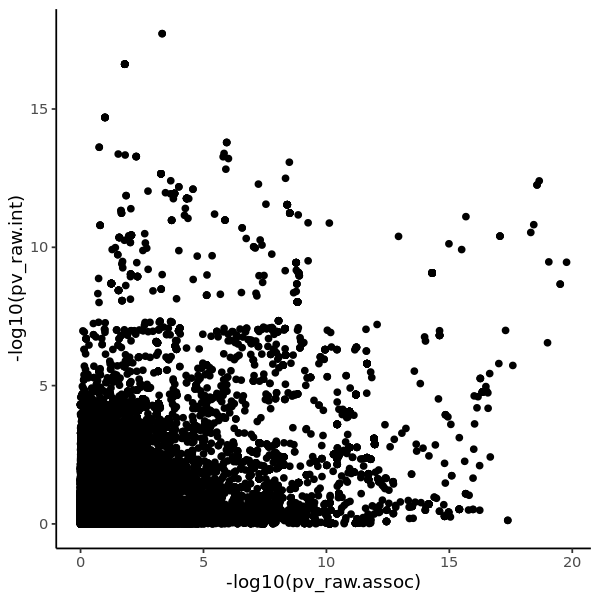

In [19]:
options(repr.plot.width = 5, repr.plot.height = 5)
p = ggplot(df_join, aes(x=-log10(pv_raw.assoc),y=-log10(pv_raw.int))) + geom_point()
p + theme_classic()

In [26]:
df_all = df_join
nrow(df_all)

[1] 221104

In [27]:
head(df_all,2)

gene,n_snps.assoc,chrom.assoc,pv_raw.assoc,snpID,pv,eqtl,n_snps.int,chrom.int,pv_raw.int,fdr,fdr_assoc
ENSG00000100206,639,22,0.4846768,22_38815543_G_T,1,ENSG00000100206-22_38815543_G_T,10,22,0.6147924,0.9999857,0.8612892
ENSG00000100206,639,22,0.5735132,22_38815767_C_T,1,ENSG00000100206-22_38815767_C_T,10,22,0.6793908,0.9999857,0.8952501


In [28]:
nrow(df_join)

[1] 221104

In [45]:
df_join$fdr_assoc = p.adjust(df_join$pv_raw.assoc, method = "BH")

In [46]:
thresholds = seq(0, 1, length.out = 100)

In [55]:
p.adjust.methods

[1] "holm"       "hochberg"   "hommel"     "bonferroni" "BH"        
[6] "BY"         "fdr"        "none"

In [63]:
df_plot = data.frame(assoc_FDR = thresholds, n_GxC=0, n_eGenes=0)
# FDR < 0.1%
for (t in thresholds){
    res = df_join[df_join$fdr_assoc < t,]
    nrow(res)
    res$fdr = p.adjust(res$pv_raw.int, method ="BY")
    df_plot[df_plot$assoc_FDR == t,"n"] = nrow(res)
    df_plot[df_plot$assoc_FDR == t,"n_GxC"] = nrow(res[res$fdr < 0.01,])
}

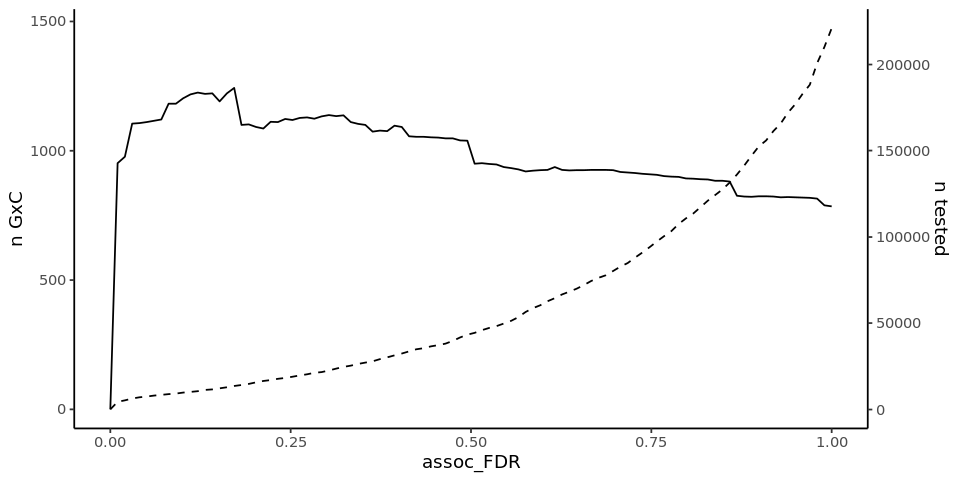

In [68]:
# other y axis: how many variants tested
coeff <- 150
options(repr.plot.width = 8, repr.plot.height = 4)
p = ggplot(df_plot, aes(x=assoc_FDR)) + theme_classic() +
  
  geom_line( aes(y=n_GxC)) + 
  geom_line( aes(y=n / coeff), linetype="dashed") + # Divide by 150 to get the same range than the GxC
  
  scale_y_continuous(
    
    # Features of the first axis
    name = "n GxC",
    
    # Add a second axis and specify its features
    sec.axis = sec_axis(~.*coeff, name="n tested")
  )
p

In [69]:
fig_dir = "/hps/nobackup2/stegle/users/acuomo/CellRegMap_data/figures/"
pdf(paste0(fig_dir,"SF9A_FDR_curve.pdf"), width=8, height=4)
p
dev.off()

png 
  2